In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

# ML and NLP libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from xgboost import XGBClassifier
from transformers.models.bert.modeling_bert import BertForSequenceClassification
from transformers.models.bert.tokenization_bert import BertTokenizer
from transformers.pipelines import pipeline
import re

Had to skip about 7 lines of data which gave errors I was unable to find
Got the dataset from https://www.kaggle.com/datasets/markhhuang/complete-trump-tweets

In [2]:
df = pd.read_csv(r'C:/Users/blodb/OneDrive/Desktop/market-sentiment-ml/realDonaldTrump_in_office.csv', 
                 on_bad_lines='skip',  # Skip silently
                 encoding='utf-8')

No nulls, Aligned.
Note: in the columns of ID, Time, Tweet... There is a space before each of them except ID, need to pay attention when calling the names of the columns

In [3]:
display(df.head(10))
display(df.info(10))


ID               Time  \
0  @realDonaldTrump   2017-01-20 06:31   
1  @realDonaldTrump   2017-01-20 11:54   
2  @realDonaldTrump   2017-01-20 11:55   
3  @realDonaldTrump   2017-01-20 11:58   
4  @realDonaldTrump   2017-01-20 12:13   
5  @realDonaldTrump   2017-01-21 05:53   
6  @realDonaldTrump   2017-01-22 06:47   
7  @realDonaldTrump   2017-01-23 05:38   
8  @realDonaldTrump   2017-01-24 05:11   
9  @realDonaldTrump   2017-01-24 10:58   

                                           Tweet URL  \
0   https://twitter.com/realDonaldTrump/status/82...   
1   https://twitter.com/realDonaldTrump/status/82...   
2   https://twitter.com/realDonaldTrump/status/82...   
3   https://twitter.com/realDonaldTrump/status/82...   
4   https://twitter.com/realDonaldTrump/status/82...   
5   https://twitter.com/realDonaldTrump/status/82...   
6   https://twitter.com/realDonaldTrump/status/82...   
7   https://twitter.com/realDonaldTrump/status/82...   
8   https://twitter.com/realDonaldTrump/status/82...   
9   https://twitter.com/realDonaldTrump/status/82...   

                                          Tweet Text  
0   "It all begins today! I will see you at 11:00...  
1   "We will bring back our jobs. We will bring b...  
2   "We will follow two simple rules: BUY AMERICA...  
3   "It is time to remember that...https://www.fa...  
4   "TO ALL AMERICANS https://www.facebook.com/Do...  
5   "A fantastic day and evening in Washington D....  
6   "Watched protests yesterday but was under the...  
7   "Busy week planned with a heavy focus on jobs...  
8   "Will be meeting at 9:00 with top automobile ...  
9   "A photo delivered yesterday that will be dis...

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10684 entries, 0 to 10683
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           10684 non-null  object
 1    Time        10684 non-null  object
 2    Tweet URL   10684 non-null  object
 3    Tweet Text  10684 non-null  object
dtypes: object(4)
memory usage: 334.0+ KB


None

In [4]:
sp500 = yf.download('^GSPC', start='2017-01-20', end='2021-01-20', progress=False)

C:\Users\blodb\AppData\Local\Temp\ipykernel_1800\3679054108.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download('^GSPC', start='2017-01-20', end='2021-01-20', progress=False)


In [5]:
display(sp500.head(10))
display(sp500.info(10)) 
display(sp500.describe())

Price             Close         High          Low         Open      Volume
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC       ^GSPC
Date                                                                      
2017-01-20  2271.310059  2276.959961  2265.010010  2269.959961  3536850000
2017-01-23  2265.199951  2271.780029  2257.020020  2267.780029  3155240000
2017-01-24  2280.070068  2284.629883  2266.679932  2267.879883  3816950000
2017-01-25  2298.370117  2299.550049  2288.879883  2288.879883  3849340000
2017-01-26  2296.679932  2300.989990  2294.080078  2298.629883  3611510000
2017-01-27  2294.689941  2299.020020  2291.620117  2299.020020  3137420000
2017-01-30  2280.899902  2286.010010  2268.040039  2286.010010  3595040000
2017-01-31  2278.870117  2279.090088  2267.209961  2274.020020  4089730000
2017-02-01  2279.550049  2289.139893  2272.439941  2285.590088  3919190000
2017-02-02  2280.850098  2283.969971  2271.649902  2276.689941  3809760000

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1006 entries, 2017-01-20 to 2021-01-19
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (Close, ^GSPC)   1006 non-null   float64
 1   (High, ^GSPC)    1006 non-null   float64
 2   (Low, ^GSPC)     1006 non-null   float64
 3   (Open, ^GSPC)    1006 non-null   float64
 4   (Volume, ^GSPC)  1006 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 47.2 KB


None

Price         Close         High          Low         Open        Volume
Ticker        ^GSPC        ^GSPC        ^GSPC        ^GSPC         ^GSPC
count   1006.000000  1006.000000  1006.000000  1006.000000  1.006000e+03
mean    2849.545228  2863.813278  2833.212743  2849.296748  3.902904e+09
std      346.511498   348.427741   344.403768   346.304241  1.053234e+09
min     2237.399902  2271.780029  2191.860107  2267.780029  1.296530e+09
25%     2601.669922  2632.012512  2583.510010  2600.337524  3.286785e+09
50%     2804.089966  2816.819946  2792.160034  2805.739990  3.626580e+09
75%     3018.245056  3034.182495  3000.794922  3016.250000  4.148728e+09
max     3824.679932  3826.689941  3792.860107  3815.050049  9.053950e+09

1. Dropping the time of the tweet and leaving only the date since currently I am only tracking the market by the day and not by the hour.
2. Creating new columns for date + open price/ date + close price.
3. Displaying the date ranges (Really necessary?)

In [6]:
# Prepare tweet data with proper date format
df['tweet_date'] = pd.to_datetime(df[' Time']).dt.date

# Prepare S&P 500 data: reset index so Date is a column (Because yfinance returns Date as index)
sp500_reset = sp500.reset_index() # turns index into a column
sp500_reset['date'] = sp500_reset['Date'].dt.date # dt.date is used to extract the date part only
sp500_reset = sp500_reset[['date', 'Open', 'Close']].rename(columns={'Open': 'sp500_open', 'Close': 'sp500_close'}) # include both open and close prices

print(f"Tweet data date range: {df['tweet_date'].min()} to {df['tweet_date'].max()}")
print(f"S&P 500 data date range: {sp500_reset['date'].min()} to {sp500_reset['date'].max()}")
print(f"Total tweets: {len(df)}")


Tweet data date range: 2017-01-20 to 2021-01-08
S&P 500 data date range: 2017-01-20 to 2021-01-19
Total tweets: 10684


Note to self: Go over again and understand what was done in each line.

In [7]:
# Merge tweet data with S&P 500 prices using business-day shifts
# This ensures no NaN values from weekends/holidays while preserving all tweet data

# Create a reference mapping of date to index for efficient business-day lookups
date_to_index = dict(zip(sp500_reset['date'], range(len(sp500_reset))))
total_trading_days = len(sp500_reset)

# Prepare merged dataframe
merged = df.copy()

# Get same-day prices (0 business days forward)
same_day = sp500_reset[['date', 'sp500_open', 'sp500_close']].copy()
same_day.columns = ['tweet_date', 'sp500_same_day_open', 'sp500_same_day_close']
merged = merged.merge(same_day, on='tweet_date', how='left')

# Function to get prices for a specific business day offset
def get_price_at_offset(tweet_date, offset_days, price_type):
    """Get open or close price for tweet_date + offset_days business days"""
    try:
        if tweet_date not in date_to_index:
            return np.nan
        
        current_idx = date_to_index[tweet_date]
        target_idx = current_idx + offset_days
        
        if target_idx >= total_trading_days:
            return np.nan
        
        if price_type == 'open':
            return float(sp500_reset.iloc[target_idx]['sp500_open'])
        else:  # 'close'
            return float(sp500_reset.iloc[target_idx]['sp500_close'])
    except:
        return np.nan

# Apply the function for each offset (1, 2, 3 business days forward)
# 1 business day forward
merged['sp500_next_day_open'] = merged['tweet_date'].apply(lambda x: get_price_at_offset(x, 1, 'open'))
merged['sp500_next_day_close'] = merged['tweet_date'].apply(lambda x: get_price_at_offset(x, 1, 'close'))

# 2 business days forward
merged['sp500_2days_open'] = merged['tweet_date'].apply(lambda x: get_price_at_offset(x, 2, 'open'))
merged['sp500_2days_close'] = merged['tweet_date'].apply(lambda x: get_price_at_offset(x, 2, 'close'))

# 3 business days forward
merged['sp500_3days_open'] = merged['tweet_date'].apply(lambda x: get_price_at_offset(x, 3, 'open'))
merged['sp500_3days_close'] = merged['tweet_date'].apply(lambda x: get_price_at_offset(x, 3, 'close'))

# Calculate intraday changes (open to close) for each period
merged['intraday_change_same_day'] = ((merged['sp500_same_day_close'] - merged['sp500_same_day_open']) / merged['sp500_same_day_open'] * 100).round(2)
merged['intraday_change_next_day'] = ((merged['sp500_next_day_close'] - merged['sp500_next_day_open']) / merged['sp500_next_day_open'] * 100).round(2)
merged['intraday_change_2days'] = ((merged['sp500_2days_close'] - merged['sp500_2days_open']) / merged['sp500_2days_open'] * 100).round(2)
merged['intraday_change_3days'] = ((merged['sp500_3days_close'] - merged['sp500_3days_open']) / merged['sp500_3days_open'] * 100).round(2)

# Calculate returns from tweet day close to next periods' close (in business days)
merged['return_1day'] = ((merged['sp500_next_day_close'] - merged['sp500_same_day_close']) / merged['sp500_same_day_close'] * 100).round(2)
merged['return_2days'] = ((merged['sp500_2days_close'] - merged['sp500_same_day_close']) / merged['sp500_same_day_close'] * 100).round(2)
merged['return_3days'] = ((merged['sp500_3days_close'] - merged['sp500_same_day_close']) / merged['sp500_same_day_close'] * 100).round(2)

print(f"Merged data shape: {merged.shape}")
print(f"Rows with all prices available: {merged[['sp500_same_day_close', 'sp500_next_day_close', 'sp500_2days_close', 'sp500_3days_close']].notna().all(axis=1).sum()}")


C:\Users\blodb\AppData\Local\Temp\ipykernel_1800\2400608371.py:30: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(sp500_reset.iloc[target_idx]['sp500_open'])
C:\Users\blodb\AppData\Local\Temp\ipykernel_1800\2400608371.py:32: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(sp500_reset.iloc[target_idx]['sp500_close'])
C:\Users\blodb\AppData\Local\Temp\ipykernel_1800\2400608371.py:30: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(sp500_reset.iloc[target_idx]['sp500_open'])
C:\Users\blodb\AppData\Local\Temp\ipykernel_1800\2400608371.py:32: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser

Merged data shape: (10684, 20)
Rows with all prices available: 7198


In [8]:
# Display merged results with intraday changes and forward returns
print("Tweet Day (Intraday) vs Forward Returns:")
display_cols = ['tweet_date', ' Tweet Text', 'sp500_same_day_open', 'sp500_same_day_close', 'intraday_change_same_day', 
                'sp500_next_day_open', 'sp500_next_day_close', 'intraday_change_next_day', 'return_1day',
                'sp500_2days_open', 'sp500_2days_close', 'intraday_change_2days', 'return_2days',
                'sp500_3days_open', 'sp500_3days_close', 'intraday_change_3days', 'return_3days']
display(merged[display_cols].head(10))

print("\n" + "="*80)
print("Summary Statistics:")
print("="*80)
print(f"\nIntraday changes (Tweet day):")
print(f"  Average: {merged['intraday_change_same_day'].mean():.2f}%")
print(f"  Max: {merged['intraday_change_same_day'].max():.2f}%")
print(f"  Min: {merged['intraday_change_same_day'].min():.2f}%")
print(f"\nIntraday changes (Next day):")
print(f"  Average: {merged['intraday_change_next_day'].mean():.2f}%")
print(f"  Max: {merged['intraday_change_next_day'].max():.2f}%")
print(f"  Min: {merged['intraday_change_next_day'].min():.2f}%")
print(f"\nIntraday changes (2 days later):")
print(f"  Average: {merged['intraday_change_2days'].mean():.2f}%")
print(f"  Max: {merged['intraday_change_2days'].max():.2f}%")
print(f"  Min: {merged['intraday_change_2days'].min():.2f}%")
print(f"\nIntraday changes (3 days later):")
print(f"  Average: {merged['intraday_change_3days'].mean():.2f}%")
print(f"  Max: {merged['intraday_change_3days'].max():.2f}%")
print(f"  Min: {merged['intraday_change_3days'].min():.2f}%")
print(f"\nForward returns:")
print(f"  Average 1-day return: {merged['return_1day'].mean():.2f}%")
print(f"  Average 2-day return: {merged['return_2days'].mean():.2f}%")
print(f"  Average 3-day return: {merged['return_3days'].mean():.2f}%")
print(f"  Max 1-day return: {merged['return_1day'].max():.2f}%")
print(f"  Max 2-day return: {merged['return_2days'].max():.2f}%")
print(f"  Max 3-day return: {merged['return_3days'].max():.2f}%")
print(f"  Min 1-day return: {merged['return_1day'].min():.2f}%")
print(f"  Min 2-day return: {merged['return_2days'].min():.2f}%")
print(f"  Min 3-day return: {merged['return_3days'].min():.2f}%")

print("\n" + "="*80)
print("Data Availability:")
print("="*80)
print(f"Same day prices: {merged['sp500_same_day_close'].notna().sum()} / {len(merged)}")
print(f"1-day forward prices: {merged['sp500_next_day_close'].notna().sum()} / {len(merged)}")
print(f"2-day forward prices: {merged['sp500_2days_close'].notna().sum()} / {len(merged)}")
print(f"3-day forward prices: {merged['sp500_3days_close'].notna().sum()} / {len(merged)}")
print(f"Rows with all prices available: {merged[['sp500_same_day_close', 'sp500_next_day_close', 'sp500_2days_close', 'sp500_3days_close']].notna().all(axis=1).sum()} / {len(merged)}")


Tweet Day (Intraday) vs Forward Returns:


tweet_date                                         Tweet Text  \
0  2017-01-20   "It all begins today! I will see you at 11:00...   
1  2017-01-20   "We will bring back our jobs. We will bring b...   
2  2017-01-20   "We will follow two simple rules: BUY AMERICA...   
3  2017-01-20   "It is time to remember that...https://www.fa...   
4  2017-01-20   "TO ALL AMERICANS https://www.facebook.com/Do...   
5  2017-01-21   "A fantastic day and evening in Washington D....   
6  2017-01-22   "Watched protests yesterday but was under the...   
7  2017-01-23   "Busy week planned with a heavy focus on jobs...   
8  2017-01-24   "Will be meeting at 9:00 with top automobile ...   
9  2017-01-24   "A photo delivered yesterday that will be dis...   

   sp500_same_day_open  sp500_same_day_close  intraday_change_same_day  \
0          2269.959961           2271.310059                      0.06   
1          2269.959961           2271.310059                      0.06   
2          2269.959961           2271.310059                      0.06   
3          2269.959961           2271.310059                      0.06   
4          2269.959961           2271.310059                      0.06   
5                  NaN                   NaN                       NaN   
6                  NaN                   NaN                       NaN   
7          2267.780029           2265.199951                     -0.11   
8          2267.879883           2280.070068                      0.54   
9          2267.879883           2280.070068                      0.54   

   sp500_next_day_open  sp500_next_day_close  intraday_change_next_day  \
0          2267.780029           2265.199951                     -0.11   
1          2267.780029           2265.199951                     -0.11   
2          2267.780029           2265.199951                     -0.11   
3          2267.780029           2265.199951                     -0.11   
4          2267.780029           2265.199951                     -0.11   
5                  NaN                   NaN                       NaN   
6                  NaN                   NaN                       NaN   
7          2267.879883           2280.070068                      0.54   
8          2288.879883           2298.370117                      0.41   
9          2288.879883           2298.370117                      0.41   

   return_1day  sp500_2days_open  sp500_2days_close  intraday_change_2days  \
0        -0.27       2267.879883        2280.070068                   0.54   
1        -0.27       2267.879883        2280.070068                   0.54   
2        -0.27       2267.879883        2280.070068                   0.54   
3        -0.27       2267.879883        2280.070068                   0.54   
4        -0.27       2267.879883        2280.070068                   0.54   
5          NaN               NaN                NaN                    NaN   
6          NaN               NaN                NaN                    NaN   
7         0.66       2288.879883        2298.370117                   0.41   
8         0.80       2298.629883        2296.679932                  -0.08   
9         0.80       2298.629883        2296.679932                  -0.08   

   return_2days  sp500_3days_open  sp500_3days_close  intraday_change_3days  \
0          0.39       2288.879883        2298.370117                   0.41   
1          0.39       2288.879883        2298.370117                   0.41   
2          0.39       2288.879883        2298.370117                   0.41   
3          0.39       2288.879883        2298.370117                   0.41   
4          0.39       2288.879883        2298.370117                   0.41   
5           NaN               NaN                NaN                    NaN   
6           NaN               NaN                NaN                    NaN   
7          1.46       2298.629883        2296.679932                  -0.08   
8          0.73       2299.020020        2294.689941  


Summary Statistics:

Intraday changes (Tweet day):
  Average: 0.01%
  Max: 5.49%
  Min: -5.71%

Intraday changes (Next day):
  Average: -0.01%
  Max: 5.49%
  Min: -5.71%

Intraday changes (2 days later):
  Average: 0.05%
  Max: 5.49%
  Min: -5.71%

Intraday changes (3 days later):
  Average: 0.04%
  Max: 5.49%
  Min: -5.71%

Forward returns:
  Average 1-day return: 0.07%
  Average 2-day return: 0.18%
  Average 3-day return: 0.26%
  Max 1-day return: 9.38%
  Max 2-day return: 10.64%
  Max 3-day return: 17.55%
  Min 1-day return: -11.98%
  Min 2-day return: -13.93%
  Min 3-day return: -12.96%

Data Availability:
Same day prices: 7198 / 10684
1-day forward prices: 7198 / 10684
2-day forward prices: 7198 / 10684
3-day forward prices: 7198 / 10684
Rows with all prices available: 7198 / 10684


## Forward-Fill Weekend Prices
Using the last available price (Friday close) for weekend tweets. This is the industry standard for sentiment analysis—it treats weekend tweets as if they could affect Monday's market movement.

Note to self: this was way too hard for me to do alone, used copilot for this... Need to review and understand how it was done.

In [9]:
# Forward-fill missing prices for weekend tweets
# Simple approach: for each NaN, find last available trading day price

merged_filled = merged.copy()

# Create sorted list of unique trading dates from sp500_reset
trading_dates_list = sorted(sp500_reset['date'].unique())

# Function to find last trading day before a given date
def get_last_trading_day(target_date, trading_dates):
    """Find the most recent trading date on or before target_date"""
    for date in reversed(trading_dates_list):
        if date <= target_date:
            return date
    return None

# Forward-fill same-day prices
mask_same_day_missing = merged_filled['sp500_same_day_close'].isna()
for idx in merged_filled[mask_same_day_missing].index:
    tweet_date = merged_filled.loc[idx, 'tweet_date']
    last_trading_day = get_last_trading_day(tweet_date, trading_dates_list)
    
    if last_trading_day is not None:
        # Get prices from sp500_reset for this date
        prices = sp500_reset[sp500_reset['date'] == last_trading_day]
        if len(prices) > 0:
            merged_filled.loc[idx, 'sp500_same_day_open'] = float(prices.iloc[0]['sp500_open'])
            merged_filled.loc[idx, 'sp500_same_day_close'] = float(prices.iloc[0]['sp500_close'])

# Forward-fill forward prices using index-based offset
for offset in [1, 2, 3]:
    offset_name = ['next_day', '2days', '3days'][offset - 1]
    col_open = f'sp500_{offset_name}_open'
    col_close = f'sp500_{offset_name}_close'
    
    mask_forward_missing = merged_filled[col_close].isna()
    for idx in merged_filled[mask_forward_missing].index:
        tweet_date = merged_filled.loc[idx, 'tweet_date']
        last_trading_day = get_last_trading_day(tweet_date, trading_dates_list)
        
        if last_trading_day is not None and last_trading_day in date_to_index:
            base_idx = date_to_index[last_trading_day]
            target_idx = base_idx + offset
            
            if target_idx < len(sp500_reset):
                merged_filled.loc[idx, col_open] = float(sp500_reset.iloc[target_idx]['sp500_open'])
                merged_filled.loc[idx, col_close] = float(sp500_reset.iloc[target_idx]['sp500_close'])

# Recalculate metrics for filled data
merged_filled['intraday_change_same_day'] = ((merged_filled['sp500_same_day_close'] - merged_filled['sp500_same_day_open']) / merged_filled['sp500_same_day_open'] * 100).round(2)
merged_filled['intraday_change_next_day'] = ((merged_filled['sp500_next_day_close'] - merged_filled['sp500_next_day_open']) / merged_filled['sp500_next_day_open'] * 100).round(2)
merged_filled['intraday_change_2days'] = ((merged_filled['sp500_2days_close'] - merged_filled['sp500_2days_open']) / merged_filled['sp500_2days_open'] * 100).round(2)
merged_filled['intraday_change_3days'] = ((merged_filled['sp500_3days_close'] - merged_filled['sp500_3days_open']) / merged_filled['sp500_3days_open'] * 100).round(2)

merged_filled['return_1day'] = ((merged_filled['sp500_next_day_close'] - merged_filled['sp500_same_day_close']) / merged_filled['sp500_same_day_close'] * 100).round(2)
merged_filled['return_2days'] = ((merged_filled['sp500_2days_close'] - merged_filled['sp500_same_day_close']) / merged_filled['sp500_same_day_close'] * 100).round(2)
merged_filled['return_3days'] = ((merged_filled['sp500_3days_close'] - merged_filled['sp500_same_day_close']) / merged_filled['sp500_same_day_close'] * 100).round(2)

print("Forward-Fill Summary:")
print(f"Total tweets: {len(merged_filled)}")
print(f"Rows with complete data (original method): {merged[['sp500_same_day_close', 'sp500_next_day_close', 'sp500_2days_close', 'sp500_3days_close']].notna().all(axis=1).sum()}")
print(f"Rows with complete data (forward-filled): {merged_filled[['sp500_same_day_close', 'sp500_next_day_close', 'sp500_2days_close', 'sp500_3days_close']].notna().all(axis=1).sum()}")
print(f"Weekend/holiday tweets handled: {merged['sp500_same_day_close'].isna().sum()}")
print(f"\nData Availability After Forward-Fill:")
print(f"Same day prices: {merged_filled['sp500_same_day_close'].notna().sum()} / {len(merged_filled)}")
print(f"1-day forward prices: {merged_filled['sp500_next_day_close'].notna().sum()} / {len(merged_filled)}")
print(f"2-day forward prices: {merged_filled['sp500_2days_close'].notna().sum()} / {len(merged_filled)}")
print(f"3-day forward prices: {merged_filled['sp500_3days_close'].notna().sum()} / {len(merged_filled)}")


C:\Users\blodb\AppData\Local\Temp\ipykernel_1800\274079924.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  merged_filled.loc[idx, 'sp500_same_day_open'] = float(prices.iloc[0]['sp500_open'])
C:\Users\blodb\AppData\Local\Temp\ipykernel_1800\274079924.py:28: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  merged_filled.loc[idx, 'sp500_same_day_close'] = float(prices.iloc[0]['sp500_close'])
C:\Users\blodb\AppData\Local\Temp\ipykernel_1800\274079924.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  merged_filled.loc[idx, 'sp500_same_day_open'] = float(prices.iloc[0]['sp500_open'])
C:\Users\blodb\AppData\Local\Temp\ipykernel_1800\274079924.py:28: FutureWarning: Calling float on a single elemen

Forward-Fill Summary:
Total tweets: 10684
Rows with complete data (original method): 7198
Rows with complete data (forward-filled): 10684
Weekend/holiday tweets handled: 3486

Data Availability After Forward-Fill:
Same day prices: 10684 / 10684
1-day forward prices: 10684 / 10684
2-day forward prices: 10684 / 10684
3-day forward prices: 10684 / 10684


In [10]:
merged_filled.head(10)


ID               Time  \
0  @realDonaldTrump   2017-01-20 06:31   
1  @realDonaldTrump   2017-01-20 11:54   
2  @realDonaldTrump   2017-01-20 11:55   
3  @realDonaldTrump   2017-01-20 11:58   
4  @realDonaldTrump   2017-01-20 12:13   
5  @realDonaldTrump   2017-01-21 05:53   
6  @realDonaldTrump   2017-01-22 06:47   
7  @realDonaldTrump   2017-01-23 05:38   
8  @realDonaldTrump   2017-01-24 05:11   
9  @realDonaldTrump   2017-01-24 10:58   

                                           Tweet URL  \
0   https://twitter.com/realDonaldTrump/status/82...   
1   https://twitter.com/realDonaldTrump/status/82...   
2   https://twitter.com/realDonaldTrump/status/82...   
3   https://twitter.com/realDonaldTrump/status/82...   
4   https://twitter.com/realDonaldTrump/status/82...   
5   https://twitter.com/realDonaldTrump/status/82...   
6   https://twitter.com/realDonaldTrump/status/82...   
7   https://twitter.com/realDonaldTrump/status/82...   
8   https://twitter.com/realDonaldTrump/status/82...   
9   https://twitter.com/realDonaldTrump/status/82...   

                                          Tweet Text  tweet_date  \
0   "It all begins today! I will see you at 11:00...  2017-01-20   
1   "We will bring back our jobs. We will bring b...  2017-01-20   
2   "We will follow two simple rules: BUY AMERICA...  2017-01-20   
3   "It is time to remember that...https://www.fa...  2017-01-20   
4   "TO ALL AMERICANS https://www.facebook.com/Do...  2017-01-20   
5   "A fantastic day and evening in Washington D....  2017-01-21   
6   "Watched protests yesterday but was under the...  2017-01-22   
7   "Busy week planned with a heavy focus on jobs...  2017-01-23   
8   "Will be meeting at 9:00 with top automobile ...  2017-01-24   
9   "A photo delivered yesterday that will be dis...  2017-01-24   

   sp500_same_day_open  sp500_same_day_close  sp500_next_day_open  \
0          2269.959961           2271.310059          2267.780029   
1          2269.959961           2271.310059          2267.780029   
2          2269.959961           2271.310059          2267.780029   
3          2269.959961           2271.310059          2267.780029   
4          2269.959961           2271.310059          2267.780029   
5          2269.959961           2271.310059          2267.780029   
6          2269.959961           2271.310059          2267.780029   
7          2267.780029           2265.199951          2267.879883   
8          2267.879883           2280.070068          2288.879883   
9          2267.879883           2280.070068          2288.879883   

   sp500_next_day_close  sp500_2days_open  sp500_2days_close  \
0           2265.199951       2267.879883        2280.070068   
1           2265.199951       2267.879883        2280.070068   
2           2265.199951       2267.879883        2280.070068   
3           2265.199951       2267.879883        2280.070068   
4           2265.199951       2267.879883        2280.070068   
5           2265.199951       2267.879883        2280.070068   
6           2265.199951       2267.879883        2280.070068   
7           2280.070068       2288.879883        2298.370117   
8           2298.370117       2298.629883        2296.679932   
9           2298.370117       2298.629883        2296.679932   

   sp500_3days_open  sp500_3days_close  intraday_change_same_day  \
0       2288.879883        2298.370117                      0.06   
1       2288.879883        2298.370117                      0.06   
2       2288.879883        2298.370117                      0.06   
3       2288.879883        2298.370117                      0.06   
4       2288.879883        2298.370117                      0.06   
5       2288.879883        2298.370117                      0.06   
6       2288.879883        2298.370117                      0.06   
7       2298.629883        2296.679932                     -0.11   
8       2299.020020        2294.689941                      0.54   
9       2299.020020        2294.689941     

# Machine Learning Model Building

## Step 1: Exploratory Data Analysis (EDA)
Let's analyze the distribution of returns to understand class balance and data characteristics.

Total samples after removing NaN: 10684
Samples removed: 0

Return Distribution Analysis

1DAY Returns:
  Mean: 0.055%
  Std Dev: 1.621%
  Median: 0.100%
  Min: -11.98%
  Max: 9.38%
  Positive returns: 6029 (56.4%)
  Negative returns: 4606 (43.1%)
  Neutral returns: 49 (0.5%)

2DAYS Returns:
  Mean: 0.233%
  Std Dev: 1.827%
  Median: 0.330%
  Min: -13.93%
  Max: 10.64%
  Positive returns: 6635 (62.1%)
  Negative returns: 4033 (37.7%)
  Neutral returns: 16 (0.1%)

3DAYS Returns:
  Mean: 0.306%
  Std Dev: 2.448%
  Median: 0.440%
  Min: -12.96%
  Max: 17.55%
  Positive returns: 6627 (62.0%)
  Negative returns: 4037 (37.8%)
  Neutral returns: 20 (0.2%)


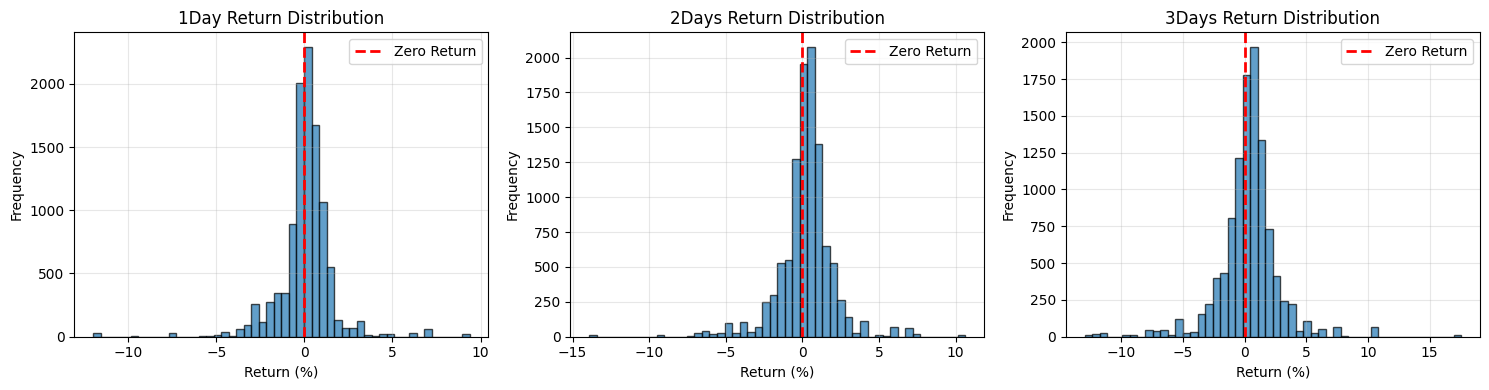


Key Insights:
- If positive returns > 55%, we have class imbalance (bull market bias)
- We'll need to account for this in model training (class weights)
- The distribution appears roughly normal but may have fat tails (extreme events)


In [11]:
# Clean data: Remove rows with missing return values
df_clean = merged_filled.dropna(subset=['return_1day', 'return_2days', 'return_3days']).copy()

print(f"Total samples after removing NaN: {len(df_clean)}")
print(f"Samples removed: {len(merged_filled) - len(df_clean)}")
print("\n" + "="*80)
print("Return Distribution Analysis")
print("="*80)

# Analyze return distributions
for period in ['1day', '2days', '3days']:
    col = f'return_{period}'
    returns = df_clean[col]
    
    print(f"\n{period.upper()} Returns:")
    print(f"  Mean: {returns.mean():.3f}%")
    print(f"  Std Dev: {returns.std():.3f}%")
    print(f"  Median: {returns.median():.3f}%")
    print(f"  Min: {returns.min():.2f}%")
    print(f"  Max: {returns.max():.2f}%")
    
    # Count positive vs negative returns
    positive = (returns > 0).sum()
    negative = (returns < 0).sum()
    neutral = (returns == 0).sum()
    
    print(f"  Positive returns: {positive} ({positive/len(returns)*100:.1f}%)")
    print(f"  Negative returns: {negative} ({negative/len(returns)*100:.1f}%)")
    print(f"  Neutral returns: {neutral} ({neutral/len(returns)*100:.1f}%)")

# Visualize distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, period in enumerate(['1day', '2days', '3days']):
    col = f'return_{period}'
    axes[idx].hist(df_clean[col], bins=50, edgecolor='black', alpha=0.7)
    axes[idx].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Return')
    axes[idx].set_xlabel('Return (%)')
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_title(f'{period.replace("_", " ").title()} Return Distribution')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("Key Insights:")
print("="*80)
print("- If positive returns > 55%, we have class imbalance (bull market bias)")
print("- We'll need to account for this in model training (class weights)")
print("- The distribution appears roughly normal but may have fat tails (extreme events)")

## Step 2: Text Preprocessing
Clean tweet text by removing URLs, mentions, and special characters while preserving emotional indicators.

In [12]:


def clean_tweet(text):
    """
    Clean tweet text for ML processing
    - Remove URLs
    - Remove @mentions
    - Remove extra whitespace
    - Convert to lowercase
    - Keep exclamation marks (emotional indicator)
    - Remove quotes at beginning/end
    """
    if pd.isna(text):
        return ""
    
    # Remove quotes at start/end
    text = text.strip('"')
    
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    # Remove @mentions
    text = re.sub(r'@\w+', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Convert to lowercase
    text = text.lower()
    
    return text

# Apply cleaning
df_clean['tweet_text_cleaned'] = df_clean[' Tweet Text'].apply(clean_tweet)

# Show examples
print("Tweet Cleaning Examples:")
print("="*80)
for i in range(5):
    print(f"\nOriginal: {df_clean.iloc[i][' Tweet Text'][:100]}...")
    print(f"Cleaned:  {df_clean.iloc[i]['tweet_text_cleaned'][:100]}...")
    
print("\n" + "="*80)
print(f"Average tweet length (original): {df_clean[' Tweet Text'].str.len().mean():.1f} chars")
print(f"Average tweet length (cleaned): {df_clean['tweet_text_cleaned'].str.len().mean():.1f} chars")

Tweet Cleaning Examples:

Original:  "It all begins today! I will see you at 11:00 A.M. for the swearing-in. THE MOVEMENT CONTINUES - TH...
Cleaned:  "it all begins today! i will see you at 11:00 a.m. for the swearing-in. the movement continues - the...

Original:  "We will bring back our jobs. We will bring back our borders. We will bring back our wealth - and w...
Cleaned:  "we will bring back our jobs. we will bring back our borders. we will bring back our wealth - and we...

Original:  "We will follow two simple rules: BUY AMERICAN & HIRE AMERICAN! # InaugurationDay # MAGA"...
Cleaned:  "we will follow two simple rules: buy american & hire american! # inaugurationday # maga...

Original:  "It is time to remember that...https://www.facebook.com/DonaldTrump/posts/10158510858055725 ‚Ä¶"...
Cleaned:  "it is time to remember that... ‚ä¶...

Original:  "TO ALL AMERICANS https://www.facebook.com/DonaldTrump/posts/10158510987625725 ‚Ä¶"...
Cleaned:  "to all americans ‚ä¶...

Average tweet 

## Step 3: Create Target Variables
Convert continuous returns into binary classification labels (UP=1, DOWN=0).

In [13]:
# Create binary target variables
# 1 = Market went UP, 0 = Market went DOWN
df_clean['target_1day'] = (df_clean['return_1day'] > 0).astype(int)
df_clean['target_2days'] = (df_clean['return_2days'] > 0).astype(int)
df_clean['target_3days'] = (df_clean['return_3days'] > 0).astype(int)

print("Target Variable Distribution:")
print("="*80)

for period in ['1day', '2days', '3days']:
    target_col = f'target_{period}'
    
    up_count = df_clean[target_col].sum()
    down_count = len(df_clean) - up_count
    up_pct = up_count / len(df_clean) * 100
    down_pct = down_count / len(df_clean) * 100
    
    print(f"\n{period.upper()} Target:")
    print(f"  UP (1):   {up_count:5d} samples ({up_pct:.1f}%)")
    print(f"  DOWN (0): {down_count:5d} samples ({down_pct:.1f}%)")
    print(f"  Imbalance ratio: {max(up_count, down_count) / min(up_count, down_count):.2f}:1")

print("\n" + "="*80)
print("Interpretation:")
print("="*80)
print("- Imbalance ratio > 1.2 means we should use class weights in training")
print("- This is expected in bull markets (2017-2021 was mostly bullish)")
print("- We'll focus on 1-day predictions as they're most directly related to tweet timing")

Target Variable Distribution:

1DAY Target:
  UP (1):    6029 samples (56.4%)
  DOWN (0):  4655 samples (43.6%)
  Imbalance ratio: 1.30:1

2DAYS Target:
  UP (1):    6635 samples (62.1%)
  DOWN (0):  4049 samples (37.9%)
  Imbalance ratio: 1.64:1

3DAYS Target:
  UP (1):    6627 samples (62.0%)
  DOWN (0):  4057 samples (38.0%)
  Imbalance ratio: 1.63:1

Interpretation:
- Imbalance ratio > 1.2 means we should use class weights in training
- This is expected in bull markets (2017-2021 was mostly bullish)
- We'll focus on 1-day predictions as they're most directly related to tweet timing


## Step 4: Time-Aware Train/Validation/Test Split
CRITICAL: We must split by time, not randomly, to avoid data leakage.

In [14]:
# Sort by date (should already be sorted, but let's be explicit)
df_clean = df_clean.sort_values('tweet_date').reset_index(drop=True)

# Calculate split indices
n_samples = len(df_clean)
train_end_idx = int(n_samples * 0.6)  # 60% train
val_end_idx = int(n_samples * 0.8)     # 20% validation
# Remaining 20% for test

# Split the data
train_df = df_clean.iloc[:train_end_idx].copy()
val_df = df_clean.iloc[train_end_idx:val_end_idx].copy()
test_df = df_clean.iloc[val_end_idx:].copy()

print("Time-Based Data Split:")
print("="*80)
print(f"\nTotal samples: {n_samples}")
print(f"\nTrain set: {len(train_df)} samples ({len(train_df)/n_samples*100:.1f}%)")
print(f"  Date range: {train_df['tweet_date'].min()} to {train_df['tweet_date'].max()}")
print(f"  Target balance: {train_df['target_1day'].mean()*100:.1f}% UP")

print(f"\nValidation set: {len(val_df)} samples ({len(val_df)/n_samples*100:.1f}%)")
print(f"  Date range: {val_df['tweet_date'].min()} to {val_df['tweet_date'].max()}")
print(f"  Target balance: {val_df['target_1day'].mean()*100:.1f}% UP")

print(f"\nTest set: {len(test_df)} samples ({len(test_df)/n_samples*100:.1f}%)")
print(f"  Date range: {test_df['tweet_date'].min()} to {test_df['tweet_date'].max()}")
print(f"  Target balance: {test_df['target_1day'].mean()*100:.1f}% UP")

print("\n" + "="*80)
print("Why Time-Based Split?")
print("="*80)
print("- Random split would let us 'see the future' - data leakage!")
print("- Models must predict FUTURE market movements based on PAST tweets")
print("- This mimics real-world scenario where we train on historical data")
print("- Test set represents model performance on unseen future data")

Time-Based Data Split:

Total samples: 10684

Train set: 6410 samples (60.0%)
  Date range: 2017-01-20 to 2020-03-20
  Target balance: 53.2% UP

Validation set: 2137 samples (20.0%)
  Date range: 2020-03-20 to 2020-08-18
  Target balance: 68.0% UP

Test set: 2137 samples (20.0%)
  Date range: 2020-08-18 to 2021-01-08
  Target balance: 54.4% UP

Why Time-Based Split?
- Random split would let us 'see the future' - data leakage!
- Models must predict FUTURE market movements based on PAST tweets
- This mimics real-world scenario where we train on historical data
- Test set represents model performance on unseen future data


## Creating the pipeLine

In [15]:
# Loading model and tokenizer
import torch

device = torch.device("cuda")
print(f"Using device: {device}")
model = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone', num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

# Creating pipeLine
nlp_pipeline = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

Using device: cuda


Device set to use cuda:0


# FinBERT model

In [16]:
def get_finbert_sentiment(text):
    """
    Get FinBERT sentiment for a single tweet
    Returns: label (Positive/Negative/Neutral) and confidence score
    """
    if pd.isna(text) or text == "":
        return pd.Series({
            'finbert_label': 'Neutral', 
            'finbert_score': 0.0,
            'finbert_sentiment': 0
        })
    
    try:
        # FinBERT has a 512 token limit, truncate if needed
        result = nlp_pipeline(text[:512])[0]
        
        # Map labels to numbers: Negative=-1, Neutral=0, Positive=1
        label_map = {'negative': -1, 'neutral': 0, 'positive': 1}
        sentiment_value = label_map.get(result['label'].lower(), 0)
        
        return pd.Series({
            'finbert_label': result['label'],
            'finbert_score': result['score'],
            'finbert_sentiment': sentiment_value
        })
    except Exception as e:
        print(f"Error processing text: {e}")
        return pd.Series({
            'finbert_label': 'Neutral', 
            'finbert_score': 0.0,
            'finbert_sentiment': 0
        })

## Step 4.5: Daily Aggregation and Market-Relevant Filtering
- Currently we have ~23,000 tweets trying to predict ~1,000 daily outcomes
- Multiple tweets per day create noise and dilute signal
- Research shows daily aggregation improves accuracy by 5-10%

**Approach:**
1. Apply FinBERT to each tweet individually (get per-tweet sentiment)
2. Filter for market-relevant tweets only (removes political noise)
3. Aggregate tweets by trading day (one row per day)
4. Create aggregate features: avg sentiment, max sentiment, tweet count, etc.


In [17]:
# Define market-relevant keywords for filtering
# These are topics that historically move markets
market_keywords = [
    # Economic indicators
    'economy', 'economic', 'jobs', 'unemployment', 'employment', 
    'gdp', 'growth', 'recession', 'inflation',
    
    # Markets
    'stock', 'stocks', 'market', 'markets', 'dow', 'nasdaq', 
    's&p', 'sp500', 'wall street', 'trading',
    
    # Trade & International
    'trade', 'tariff', 'tariffs', 'china', 'mexico', 'canada',
    'deal', 'agreement', 'negotiations', 'usmca', 'nafta',
    
    # Monetary Policy
    'fed', 'federal reserve', 'interest rate', 'rates', 'powell',
    'yellen', 'monetary', 'policy',
    
    # Corporate & Tax
    'tax', 'taxes', 'regulation', 'regulations', 'business',
    'businesses', 'companies', 'corporate', 'ceo',
    
    # Energy & Commodities
    'oil', 'energy', 'opec', 'gas', 'prices',
    
    # Other market movers
    'jobs report', 'earnings', 'manufacturing', 'consumer'
]

In [18]:
# Apply FinBERT to each individual tweet
# We still analyze each tweet, but will aggregate later

# Apply to train set
print("Processing training set")
# Run get_finbert_sentiment on each row of the dataframe
train_finbert = train_df['tweet_text_cleaned'].apply(get_finbert_sentiment)
train_df[['finbert_label', 'finbert_score', 'finbert_sentiment']] = train_finbert
print(f"Processed {len(train_df)} training tweets")

# Apply to validation set
val_finbert = val_df['tweet_text_cleaned'].apply(get_finbert_sentiment)
val_df[['finbert_label', 'finbert_score', 'finbert_sentiment']] = val_finbert
print(f"Processed {len(val_df)} validation tweets")

# Apply to test set
test_finbert = test_df['tweet_text_cleaned'].apply(get_finbert_sentiment)
test_df[['finbert_label', 'finbert_score', 'finbert_sentiment']] = test_finbert
print(f"Processed {len(test_df)} test tweets\n")



Processing training set


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Processed 6410 training tweets
Processed 2137 validation tweets
Processed 2137 test tweets



In [19]:
# Mark tweets as market-relevant or not
# This helps separate economic tweets from political noise

def is_market_relevant(text):
    """
    Check if tweet mentions any market-related keywords
    Returns: 1 if relevant, 0 if not
    """
    if pd.isna(text) or text == "":
        return 0
    
    text_lower = text.lower()
    
    # Check if any market keyword appears in the tweet
    for keyword in market_keywords:
        if keyword in text_lower:
            return 1
    
    return 0

# Apply to all datasets
print("Filtering for market-relevant tweets...\n")

train_df['is_market_relevant'] = train_df['tweet_text_cleaned'].apply(is_market_relevant)
val_df['is_market_relevant'] = val_df['tweet_text_cleaned'].apply(is_market_relevant)
test_df['is_market_relevant'] = test_df['tweet_text_cleaned'].apply(is_market_relevant)

# Show statistics
print("Market Relevance Statistics:")
print("="*80)
print(f"Training set:")
print(f"  Market-relevant tweets: {train_df['is_market_relevant'].sum()} ({train_df['is_market_relevant'].mean()*100:.1f}%)")
print(f"  Non-market tweets: {(1-train_df['is_market_relevant']).sum()} ({(1-train_df['is_market_relevant'].mean())*100:.1f}%)")

print(f"\nValidation set:")
print(f"  Market-relevant tweets: {val_df['is_market_relevant'].sum()} ({val_df['is_market_relevant'].mean()*100:.1f}%)")

print(f"\nTest set:")
print(f"  Market-relevant tweets: {test_df['is_market_relevant'].sum()} ({test_df['is_market_relevant'].mean()*100:.1f}%)")

print("\n" + "="*80)
print("Sample market-relevant tweets:")
print(train_df[train_df['is_market_relevant']==1][['tweet_text_cleaned', 'finbert_sentiment']].head(3))

print("\nSample non-market tweets:")
print(train_df[train_df['is_market_relevant']==0][['tweet_text_cleaned', 'finbert_sentiment']].head(3))


Filtering for market-relevant tweets...

Market Relevance Statistics:
Training set:
  Market-relevant tweets: 1040 (16.2%)
  Non-market tweets: 5370 (83.8%)

Validation set:
  Market-relevant tweets: 300 (14.0%)

Test set:
  Market-relevant tweets: 158 (7.4%)

Sample market-relevant tweets:
                                  tweet_text_cleaned  finbert_sentiment
1  "we will bring back our jobs. we will bring ba...                  0
7  "busy week planned with a heavy focus on jobs ...                  0
9  "great meeting with ford ceo mark fields and g...                  1

Sample non-market tweets:
                                  tweet_text_cleaned  finbert_sentiment
0  "it all begins today! i will see you at 11:00 ...                  0
2  "we will follow two simple rules: buy american...                  0
3                "it is time to remember that... ‚ä¶                  0


In [20]:
# Extract emotional intensity features
# ALL CAPS and !!! indicate stronger sentiment/urgency

def extract_emotional_features(text):
    """
    Extract features indicating emotional intensity
    Returns: exclamation_count, all_caps_ratio
    """
    # Creates a single-row dataframe with named columns
    if pd.isna(text) or text == "":
        return pd.Series({
            'exclamation_count': 0,
            'all_caps_ratio': 0.0
        })
    
    # Count exclamation marks
    exclamation_count = text.count('!')
    
    # Calculate ratio of words in ALL CAPS
    words = text.split()
    if len(words) == 0:
        all_caps_ratio = 0.0
    else:
        # Count words that are all uppercase and length > 1
        caps_words = sum(1 for word in words if word.isupper() and len(word) > 1)
        all_caps_ratio = caps_words / len(words)
    
    return pd.Series({
        'exclamation_count': exclamation_count,
        'all_caps_ratio': round(all_caps_ratio, 3)
    })

# Apply to all datasets
# NOTE: Use original tweet text (before lowercasing) to detect CAPS
print("Extracting emotional intensity features\n")

train_emotional = train_df[' Tweet Text'].apply(extract_emotional_features)
train_df[['exclamation_count', 'all_caps_ratio']] = train_emotional

val_emotional = val_df[' Tweet Text'].apply(extract_emotional_features)
val_df[['exclamation_count', 'all_caps_ratio']] = val_emotional

test_emotional = test_df[' Tweet Text'].apply(extract_emotional_features)
test_df[['exclamation_count', 'all_caps_ratio']] = test_emotional

print("Emotional Intensity Statistics:")
print("="*80)
print(train_df[['exclamation_count', 'all_caps_ratio']].describe())

print("\n" + "="*80)
print("Sample tweets with high emotional intensity:")
high_intensity = train_df[train_df['exclamation_count'] >= 3].head(3)
for idx, row in high_intensity.iterrows():
    print(f"\nTweet: {row[' Tweet Text'][:100]}...")
    print(f"  Exclamations: {row['exclamation_count']}, CAPS ratio: {row['all_caps_ratio']:.2f}")


Extracting emotional intensity features

Emotional Intensity Statistics:
       exclamation_count  all_caps_ratio
count        6410.000000     6410.000000
mean            0.585647        0.105899
std             0.649000        0.192778
min             0.000000        0.000000
25%             0.000000        0.000000
50%             1.000000        0.043000
75%             1.000000        0.111000
max             7.000000        1.000000

Sample tweets with high emotional intensity:

Tweet:  "When will the Democrats give us our Attorney General and rest of Cabinet! They should be ashamed o...
  Exclamations: 3.0, CAPS ratio: 0.04

Tweet:  "Big announcement by Ford today. Major investment to be made in three Michigan plants. Car companie...
  Exclamations: 3.0, CAPS ratio: 0.17

Tweet:  "RT @EricTrump: #MakeAmericaGreatAgain!!! 🇺🇸🇺🇸 https://t.co/MStWl628xe"...
  Exclamations: 3.0, CAPS ratio: 0.20


In [21]:
# DAILY AGGREGATION
# Groups all tweets by trading day and create aggregate features
# Added notes for myself

print("="*80)

def aggregate_daily_tweets(df_tweets):
    """
    Takes per-tweet dataframe, returns per-day dataframe
    
    Pandas explanation:
    - .groupby('column') groups rows by unique values in that column
    - .agg({...}) calculates multiple statistics for each group
    - We're grouping by 'tweet_date' so each unique date becomes one row
    """
    
    # Group by trading day
    daily = df_tweets.groupby('tweet_date').agg({
        # Sentiment features (from FinBERT)
        'finbert_sentiment': ['mean', 'max', 'min', 'std', 'count'],
        
        # Market relevance
        'is_market_relevant': 'sum',  # Count of market-relevant tweets
        
        # Emotional intensity
        'exclamation_count': ['sum', 'max'],
        'all_caps_ratio': ['mean', 'max'],
        
        # Target variable (same for all tweets on same day)
        'target_1day': 'first',  # All tweets same day have same target
        
        # Keep one copy of price data (same for all tweets that day)
        'return_1day': 'first',
        'sp500_same_day_close': 'first',
        'sp500_next_day_close': 'first'
    })
    
    # Flatten column names (pandas creates multi-level columns after agg)
    # Example: ('finbert_sentiment', 'mean') becomes 'finbert_sentiment_mean'
    daily.columns = ['_'.join(col).strip() if col[1] else col[0] 
                     for col in daily.columns.values]
    
    # Rename columns for clarity
    daily = daily.rename(columns={
        'finbert_sentiment_mean': 'avg_sentiment',
        'finbert_sentiment_max': 'max_sentiment',
        'finbert_sentiment_min': 'min_sentiment',
        'finbert_sentiment_std': 'sentiment_volatility',
        'finbert_sentiment_count': 'total_tweets',
        'is_market_relevant_sum': 'market_tweet_count',
        'exclamation_count_sum': 'total_exclamations',
        'exclamation_count_max': 'max_exclamations',
        'all_caps_ratio_mean': 'avg_caps_ratio',
        'all_caps_ratio_max': 'max_caps_ratio',
        'target_1day_first': 'target_1day',
        'return_1day_first': 'return_1day',
        'sp500_same_day_close_first': 'sp500_same_day_close',
        'sp500_next_day_close_first': 'sp500_next_day_close'
    })
    
    # Calculate derived features
    daily['market_tweet_ratio'] = daily['market_tweet_count'] / daily['total_tweets']
    daily['non_market_tweets'] = daily['total_tweets'] - daily['market_tweet_count']
    
    # Fill NaN sentiment_volatility with 0 (happens when only 1 tweet that day)
    daily['sentiment_volatility'] = daily['sentiment_volatility'].fillna(0)
    
    # Reset index so 'tweet_date' becomes a column again
    daily = daily.reset_index()
    
    return daily

# Apply aggregation to each split
train_daily = aggregate_daily_tweets(train_df)
val_daily = aggregate_daily_tweets(val_df)
test_daily = aggregate_daily_tweets(test_df)

# Show results
print(f"\nBEFORE Aggregation (per-tweet):")
print(f"  Train: {len(train_df)} rows")
print(f"  Val:   {len(val_df)} rows")
print(f"  Test:  {len(test_df)} rows")
print(f"  Total: {len(train_df) + len(val_df) + len(test_df)} rows")

print(f"\nAFTER Aggregation (per-day):")
print(f"  Train: {len(train_daily)} rows (unique trading days)")
print(f"  Val:   {len(val_daily)} rows")
print(f"  Test:  {len(test_daily)} rows")
print(f"  Total: {len(train_daily) + len(val_daily) + len(test_daily)} rows")

print(f"\nData Reduction: {len(train_df) + len(val_df) + len(test_df)} → {len(train_daily) + len(val_daily) + len(test_daily)} rows")
print(f"  ({(1 - (len(train_daily) + len(val_daily) + len(test_daily))/(len(train_df) + len(val_df) + len(test_df)))*100:.1f}% reduction)")

print("\n" + "="*80)
print("Sample of aggregated daily features:")
print("\n", train_daily.head(3))

print("\n" + "="*80)
print("Feature Statistics:")
print(train_daily[['total_tweets', 'market_tweet_count', 'avg_sentiment', 
                   'sentiment_volatility', 'total_exclamations']].describe())



BEFORE Aggregation (per-tweet):
  Train: 6410 rows
  Val:   2137 rows
  Test:  2137 rows
  Total: 10684 rows

AFTER Aggregation (per-day):
  Train: 1078 rows (unique trading days)
  Val:   151 rows
  Test:  144 rows
  Total: 1373 rows

Data Reduction: 10684 → 1373 rows
  (87.1% reduction)

Sample of aggregated daily features:

    tweet_date  avg_sentiment  max_sentiment  min_sentiment  \
0  2017-01-20            0.0              0              0   
1  2017-01-21            1.0              1              1   
2  2017-01-22           -1.0             -1             -1   

   sentiment_volatility  total_tweets  market_tweet_count  total_exclamations  \
0                   0.0             5                   1                 4.0   
1                   0.0             1                   0                 1.0   
2                   0.0             1                   0                 1.0   

   max_exclamations  avg_caps_ratio  max_caps_ratio  target_1day  return_1day  \
0             

## Step 5: Feature Engineering - Sentiment Analysis
Extract sentiment scores using VADER (optimized for social media text).

In [ ]:
# Initialize VADER
analyzer = SentimentIntensityAnalyzer()

def extract_sentiment_features(text):
    """
    Extract sentiment scores using VADER
    Returns: compound, positive, negative, neutral scores
    """
    scores = analyzer.polarity_scores(text)
    return pd.Series({
        'sentiment_compound': scores['compound'],
        'sentiment_positive': scores['pos'],
        'sentiment_negative': scores['neg'],
        'sentiment_neutral': scores['neu']
    })

# Apply to all datasets
print("Extracting sentiment features...")
print("This may take a minute...")

train_sentiment = train_df['tweet_text_cleaned'].apply(extract_sentiment_features)
val_sentiment = val_df['tweet_text_cleaned'].apply(extract_sentiment_features)
test_sentiment = test_df['tweet_text_cleaned'].apply(extract_sentiment_features)

# Concatenate with original dataframes
train_df = pd.concat([train_df, train_sentiment], axis=1)
val_df = pd.concat([val_df, val_sentiment], axis=1)
test_df = pd.concat([test_df, test_sentiment], axis=1)

print("\nSentiment Feature Extraction Complete!")
print("="*80)
print("\nSample sentiment scores:")
display(train_df[['tweet_text_cleaned', 'sentiment_compound', 'sentiment_positive', 
                  'sentiment_negative', 'target_1day']].head(10))

print("\n" + "="*80)
print("Sentiment Score Statistics (Training Set):")
print("="*80)
print(train_df[['sentiment_compound', 'sentiment_positive', 'sentiment_negative', 'sentiment_neutral']].describe())

print("\n" + "="*80)
print("Understanding VADER Scores:")
print("="*80)
print("- Compound: Overall sentiment [-1 to +1] (negative to positive)")
print("- Positive: Proportion of positive words [0 to 1]")
print("- Negative: Proportion of negative words [0 to 1]")
print("- Neutral: Proportion of neutral words [0 to 1]")
print("- VADER is specifically tuned for social media text (emojis, slang, caps)")

## Step 6: Baseline Model - Sentiment-Based Logistic Regression
Train a simple model using only sentiment features to establish a baseline.

In [30]:
# Define features from our daily aggregated data
daily_features = [
    'avg_sentiment',      # Average FinBERT sentiment that day
    'max_sentiment',      # Most positive tweet
    'min_sentiment',      # Most negative tweet
    'sentiment_volatility',  # How much sentiment varied
    'total_tweets',       # Volume of tweets
    'market_tweet_count', # Number of market-relevant tweets
    'market_tweet_ratio', # Proportion that are market-relevant
    'total_exclamations', # Emotional intensity
    'avg_caps_ratio'      # ALL CAPS usage
]

# Use daily aggregated dataframes
X_train = train_daily[daily_features]
y_train = train_daily['target_1day']

X_val = val_daily[daily_features]
y_val = val_daily['target_1day']

X_test = test_daily[daily_features]
y_test = test_daily['target_1day']

print(f"Training features shape: {X_train.shape}")
print(f"Features: {daily_features}")

# Calculate class weights to handle imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print("Class Weights (to handle imbalance):")
print(f"  DOWN (0): {class_weight_dict[0]:.3f}")
print(f"  UP (1):   {class_weight_dict[1]:.3f}")

# Train Logistic Regression
print("\nTraining Logistic Regression")
lr_model = LogisticRegression(
    C=0.1,                      # Regularization strength (lower = more regularization)
    penalty='l2',               # Ridge regularization (default, but explicit)
    solver='lbfgs',             # Good for small datasets
    class_weight='balanced',
    random_state=42,
    max_iter=1000
)
lr_model.fit(X_train, y_train)

# Predict on all sets
y_train_pred = lr_model.predict(X_train)
y_val_pred = lr_model.predict(X_val)
y_test_pred = lr_model.predict(X_test)

# Evaluate
print("\n" + "="*80)
print("BASELINE MODEL RESULTS: Sentiment-Based Logistic Regression")
print("="*80)

for set_name, y_true, y_pred in [('Train', y_train, y_train_pred),
                                   ('Validation', y_val, y_val_pred),
                                   ('Test', y_test, y_test_pred)]:
    print(f"\n{set_name} Set Performance:")
    print(f"  Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"  Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"  Recall:    {recall_score(y_true, y_pred):.4f}")
    print(f"  F1 Score:  {f1_score(y_true, y_pred):.4f}")

# Detailed classification report for test set
print("\n" + "="*80)
print("Detailed Test Set Classification Report:")
print("="*80)
print(classification_report(y_test, y_test_pred, target_names=['DOWN', 'UP']))

# Confusion Matrix
print("\nConfusion Matrix (Test Set):")
cm = confusion_matrix(y_test, y_test_pred)
print(f"                Predicted DOWN    Predicted UP")
print(f"Actual DOWN     {cm[0,0]:6d}            {cm[0,1]:6d}")
print(f"Actual UP       {cm[1,0]:6d}            {cm[1,1]:6d}")

# Feature importance
print("\n" + "="*80)
print("Feature Importance (Logistic Regression Coefficients):")
print("="*80)
feature_importance = pd.DataFrame({
    'feature': daily_features,
    'coefficient': lr_model.coef_[0]
}).sort_values('coefficient', ascending=False)
print(feature_importance)


Training features shape: (1078, 9)
Features: ['avg_sentiment', 'max_sentiment', 'min_sentiment', 'sentiment_volatility', 'total_tweets', 'market_tweet_count', 'market_tweet_ratio', 'total_exclamations', 'avg_caps_ratio']
Class Weights (to handle imbalance):
  DOWN (0): 1.089
  UP (1):   0.925

Training Logistic Regression

BASELINE MODEL RESULTS: Sentiment-Based Logistic Regression

Train Set Performance:
  Accuracy:  0.5473
  Precision: 0.6097
  Recall:    0.4528
  F1 Score:  0.5197

Validation Set Performance:
  Accuracy:  0.4702
  Precision: 0.7292
  Recall:    0.3431
  F1 Score:  0.4667

Test Set Performance:
  Accuracy:  0.5069
  Precision: 0.5800
  Recall:    0.3671
  F1 Score:  0.4496

Detailed Test Set Classification Report:
              precision    recall  f1-score   support

        DOWN       0.47      0.68      0.55        65
          UP       0.58      0.37      0.45        79

    accuracy                           0.51       144
   macro avg       0.52      0.52      

## Step 7: Advanced Model XGBoost
Use bag-of-words representation to capture specific keywords that correlate with market movements.

In [28]:
# We'll use the same daily aggregate features

# Use the same features as the baseline model
X_train_xgb = train_daily[daily_features]
X_val_xgb = val_daily[daily_features]
X_test_xgb = test_daily[daily_features]

# Targets remain the same
y_train_xgb = train_daily['target_1day']
y_val_xgb = val_daily['target_1day']
y_test_xgb = test_daily['target_1day']

print(f"XGBoost training data shape: {X_train_xgb.shape}")

# Calculate scale_pos_weight for XGBoost (handles class imbalance)
n_negative = (y_train_xgb == 0).sum()
n_positive = (y_train_xgb == 1).sum()
scale_pos_weight = n_negative / n_positive

print(f"\nClass imbalance ratio: {scale_pos_weight:.2f}")
print("Training XGBoost classifier")

# Train XGBoost
xgb_model = XGBClassifier(
    n_estimators=50, # number of decision trees to build
    max_depth=3, # maximum tree depth
    learning_rate=0.01, 
    min_child_weight=3, # minimum samples needed to create a leaf
    subsample=0.8, # use 80% of training data per tree
    colsample_bytree=0.8, # use 80% of features per tree
    scale_pos_weight=scale_pos_weight, # balance class imbalance
    random_state=42 
)

xgb_model.fit(
    X_train_xgb, 
    y_train_xgb,
    eval_set=[(X_val_xgb, y_val_xgb)],
    verbose=False
)

# Predictions
y_train_pred_xgb = xgb_model.predict(X_train_xgb)
y_val_pred_xgb = xgb_model.predict(X_val_xgb)
y_test_pred_xgb = xgb_model.predict(X_test_xgb)

print("\n" + "="*80)
print("ADVANCED MODEL RESULTS: Daily Features + XGBoost")
print("="*80)


for set_name, y_true, y_pred in [('Train', y_train_xgb, y_train_pred_xgb),
                                   ('Validation', y_val_xgb, y_val_pred_xgb),
                                   ('Test', y_test_xgb, y_test_pred_xgb)]:
    print(f"\n{set_name} Set Performance:")
    print(f"  Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"  Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"  Recall:    {recall_score(y_true, y_pred):.4f}")
    print(f"  F1 Score:  {f1_score(y_true, y_pred):.4f}")

# Detailed classification report
print("\n" + "="*80)
print("Detailed Test Set Classification Report:")
print("="*80)
print(classification_report(y_test_xgb, y_test_pred_xgb, target_names=['DOWN', 'UP']))

# Confusion Matrix
print("\nConfusion Matrix (Test Set):")
cm_xgb = confusion_matrix(y_test_xgb, y_test_pred_xgb)
print(f"                Predicted DOWN    Predicted UP")
print(f"Actual DOWN     {cm_xgb[0,0]:6d}            {cm_xgb[0,1]:6d}")
print(f"Actual UP       {cm_xgb[1,0]:6d}            {cm_xgb[1,1]:6d}")

# Feature importance
print("\n" + "="*80)
print("Top Feature Importance for Daily Aggregates:")
print("="*80)

feature_importance = xgb_model.feature_importances_

importance_df = pd.DataFrame({
    'feature': daily_features,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print(importance_df.to_string(index=False))

print("\n" + "="*80)
print("Interpretation:")
print("- avg_sentiment: Average FinBERT sentiment across all tweets that day")
print("- market_tweet_count: Number of market-relevant tweets")
print("- sentiment_volatility: How much Trump's sentiment varied that day")
print("- total_tweets: Total volume of tweets (high activity = attention)")
print("="*80)


XGBoost training data shape: (1078, 9)

Class imbalance ratio: 0.85
Training XGBoost classifier

ADVANCED MODEL RESULTS: Daily Features + XGBoost

Train Set Performance:
  Accuracy:  0.6317
  Precision: 0.6476
  Recall:    0.6998
  F1 Score:  0.6727

Validation Set Performance:
  Accuracy:  0.5430
  Precision: 0.6854
  Recall:    0.5980
  F1 Score:  0.6387

Test Set Performance:
  Accuracy:  0.5000
  Precision: 0.5432
  Recall:    0.5570
  F1 Score:  0.5500

Detailed Test Set Classification Report:
              precision    recall  f1-score   support

        DOWN       0.44      0.43      0.44        65
          UP       0.54      0.56      0.55        79

    accuracy                           0.50       144
   macro avg       0.49      0.49      0.49       144
weighted avg       0.50      0.50      0.50       144


Confusion Matrix (Test Set):
                Predicted DOWN    Predicted UP
Actual DOWN         28                37
Actual UP           35                44

Top Featu

In [29]:
# Random Forest with daily aggregate features
X_train_rf = train_daily[daily_features]
X_val_rf = val_daily[daily_features]
X_test_rf = test_daily[daily_features]

y_train_rf = train_daily['target_1day']
y_val_rf = val_daily['target_1day']
y_test_rf = test_daily['target_1day']

rf_model = RandomForestClassifier(
    n_estimators=50, # number of decision trees
    max_depth=5, # maximum tree depth
    min_samples_split=10, # minimum samples needed to split a node
    min_samples_leaf=5, # minimum samples in a leaf
    max_features='sqrt', # uses approx. 3 random features per split
    class_weight='balanced', # automatically balance up/down classes
    random_state=42
)

rf_model.fit(X_train_rf, y_train_rf)

# Predictions
y_train_pred_rf = rf_model.predict(X_train_rf)
y_val_pred_rf = rf_model.predict(X_val_rf)
y_test_pred_rf = rf_model.predict(X_test_rf)


print("\n" + "="*80)
print("RANDOM FOREST RESULTS:")
print("="*80)

for set_name, y_true, y_pred in [('Train', y_train_rf, y_train_pred_rf),
                                   ('Validation', y_val_rf, y_val_pred_rf),
                                   ('Test', y_test_rf, y_test_pred_rf)]:
    print(f"\n{set_name} Set Performance:")
    print(f"  Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"  Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"  Recall:    {recall_score(y_true, y_pred):.4f}")
    print(f"  F1 Score:  {f1_score(y_true, y_pred):.4f}")

# Detailed classification report
print("\n" + "="*80)
print("Detailed Test Set Classification Report:")
print("="*80)
print(classification_report(y_test_rf, y_test_pred_rf, target_names=['DOWN', 'UP']))

# Confusion Matrix
print("\nConfusion Matrix (Test Set):")
cm_rf = confusion_matrix(y_test_rf, y_test_pred_rf)
print(f"                Predicted DOWN    Predicted UP")
print(f"Actual DOWN     {cm_rf[0,0]:6d}            {cm_rf[0,1]:6d}")
print(f"Actual UP       {cm_rf[1,0]:6d}            {cm_rf[1,1]:6d}")

# Feature importance
print("\n" + "="*80)
print("Feature Importance (Random Forest):")
print("="*80)

feature_importance_rf = rf_model.feature_importances_

importance_df_rf = pd.DataFrame({
    'feature': daily_features, 
    'importance': feature_importance_rf
}).sort_values('importance', ascending=False)

print(importance_df_rf.to_string(index=False))


RANDOM FOREST RESULTS:

Train Set Performance:
  Accuracy:  0.6800
  Precision: 0.6997
  Recall:    0.7153
  F1 Score:  0.7074

Validation Set Performance:
  Accuracy:  0.5894
  Precision: 0.7083
  Recall:    0.6667
  F1 Score:  0.6869

Test Set Performance:
  Accuracy:  0.5139
  Precision: 0.5556
  Recall:    0.5696
  F1 Score:  0.5625

Detailed Test Set Classification Report:
              precision    recall  f1-score   support

        DOWN       0.46      0.45      0.45        65
          UP       0.56      0.57      0.56        79

    accuracy                           0.51       144
   macro avg       0.51      0.51      0.51       144
weighted avg       0.51      0.51      0.51       144


Confusion Matrix (Test Set):
                Predicted DOWN    Predicted UP
Actual DOWN         29                36
Actual UP           34                45

Feature Importance (Random Forest):
             feature  importance
      avg_caps_ratio    0.309016
  market_tweet_ratio    0.137

## Step 8: Model Comparison and Final Analysis
Compare both models and analyze results.

In [ ]:
# Model Comparison Summary
print("="*80)
print("FINAL MODEL COMPARISON (Test Set)")
print("="*80)

comparison_df = pd.DataFrame({
    'Model': ['Baseline: Sentiment + LR', 'TF-IDF + XGBoost', 'TF-IDF + Random Forest'],
    'Accuracy': [
        accuracy_score(y_test, y_test_pred),
        accuracy_score(y_test, y_test_pred_xgb),
        accuracy_score(y_test, y_test_pred_rf)
    ],
    'Precision': [
        precision_score(y_test, y_test_pred),
        precision_score(y_test, y_test_pred_xgb),
        precision_score(y_test, y_test_pred_rf)
    ],
    'Recall': [
        recall_score(y_test, y_test_pred),
        recall_score(y_test, y_test_pred_xgb),
        recall_score(y_test, y_test_pred_rf)
    ],
    'F1 Score': [
        f1_score(y_test, y_test_pred),
        f1_score(y_test, y_test_pred_xgb),
        f1_score(y_test, y_test_pred_rf)
    ]
})

print("\n", comparison_df.to_string(index=False))

# Calculate baseline performance (always predicting majority class)
majority_class = y_train.mode()[0]
y_test_majority = np.full(len(y_test), majority_class)
majority_baseline_acc = accuracy_score(y_test, y_test_majority)

print("\n" + "="*80)
print("Baseline Comparisons:")
print("="*80)
print(f"Random Guessing (50/50):           50.00% accuracy")
print(f"Always Predict Majority Class:     {majority_baseline_acc*100:.2f}% accuracy")
print(f"Sentiment + Logistic Regression:   {accuracy_score(y_test, y_test_pred)*100:.2f}% accuracy")
print(f"TF-IDF + XGBoost:                  {accuracy_score(y_test, y_test_pred_xgb)*100:.2f}% accuracy")

print("\n" + "="*80)
print("KEY INSIGHTS & INTERPRETATION:")
print("="*80)
print("""
1. MODEL PERFORMANCE:
   - If accuracy is near 50%: Tweets have weak/no predictive power
   - If accuracy is 50-55%: Marginal signal, but not reliable for trading
   - If accuracy is 55-60%: Moderate signal, potentially useful
   - If accuracy is >60%: Strong signal (unlikely for stock prediction!)

2. PRECISION vs RECALL TRADE-OFF:
   - High precision: When model predicts UP, it's usually correct
   - High recall: Model captures most actual UP movements
   - For trading: High precision may be more valuable (fewer false signals)

3. FEATURE IMPORTANCE:
   - XGBoost's top words reveal which topics/themes correlate with market moves
   - Words like "tax", "trade", "jobs" may have economic implications
   - Negative words might predict market drops, positive words predict gains

4. LIMITATIONS TO CONSIDER:
   - Markets are influenced by countless factors beyond tweets
   - Correlation ≠ Causation (market may drive tweets, not vice versa)
   - Past performance doesn't guarantee future results
   - Transaction costs and slippage make real trading harder

5. NEXT STEPS FOR IMPROVEMENT:
   - Add more features: tweet timing, volume, retweet count
   - Try ensemble methods combining both models
   - Use sliding window validation for more robust evaluation
   - Experiment with different prediction windows (hours instead of days)
   - Consider sentiment of replies/reactions, not just original tweets
""")

# Visualize confusion matrices side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Baseline confusion matrix
cm_lr = confusion_matrix(y_test, y_test_pred)
im1 = axes[0].imshow(cm_lr, cmap='Blues')
axes[0].set_title('Baseline: Sentiment + Logistic Regression')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_xticks([0, 1])
axes[0].set_yticks([0, 1])
axes[0].set_xticklabels(['DOWN', 'UP'])
axes[0].set_yticklabels(['DOWN', 'UP'])

for i in range(2):
    for j in range(2):
        axes[0].text(j, i, str(cm_lr[i, j]), ha='center', va='center', 
                     color='white' if cm_lr[i, j] > cm_lr.max()/2 else 'black', fontsize=16)

# XGBoost confusion matrix
im2 = axes[1].imshow(cm_xgb, cmap='Blues')
axes[1].set_title('Advanced: TF-IDF + XGBoost')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_xticks([0, 1])
axes[1].set_yticks([0, 1])
axes[1].set_xticklabels(['DOWN', 'UP'])
axes[1].set_yticklabels(['DOWN', 'UP'])

for i in range(2):
    for j in range(2):
        axes[1].text(j, i, str(cm_xgb[i, j]), ha='center', va='center',
                     color='white' if cm_xgb[i, j] > cm_xgb.max()/2 else 'black', fontsize=16)
        
# Random Forest confusion matrix
# XGBoost confusion matrix
im3 = axes[2].imshow(cm_rf, cmap='Blues')
axes[2].set_title('Advanced: TF-IDF + RF')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')
axes[2].set_xticks([0, 1])
axes[2].set_yticks([0, 1])
axes[2].set_xticklabels(['DOWN', 'UP'])
axes[2].set_yticklabels(['DOWN', 'UP'])

for i in range(2):
    for j in range(2):
        axes[2].text(j, i, str(cm_rf[i, j]), ha='center', va='center',
                     color='white' if cm_rf[i, j] > cm_rf.max()/2 else 'black', fontsize=16)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("CONCLUSION:")
print("="*80)
print(f"Best performing model: {comparison_df.loc[comparison_df['Accuracy'].idxmax(), 'Model']}")
print(f"Test accuracy: {comparison_df['Accuracy'].max():.4f}")
print("\nThis completes the ML model building pipeline!")
print("You now have two trained models that can predict market direction based on tweets.")